In [ ]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate
from gsnn.simulate.datasets import simulate_3_in_3_out
from gsnn.interpret.GSNNExplainer import GSNNExplainer
from captum.attr import IntegratedGradients

import pandas as pd

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


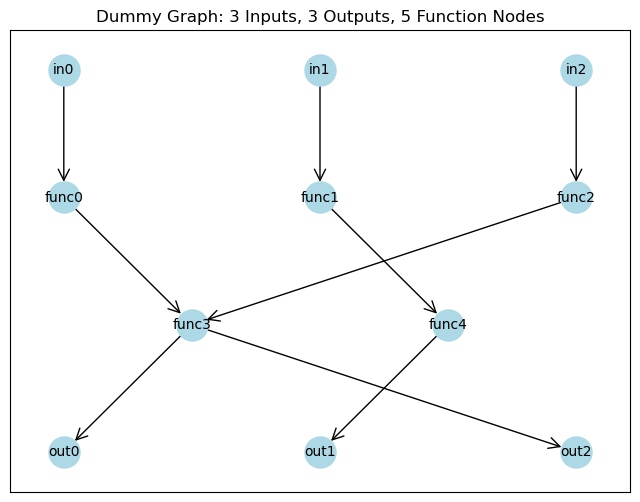

In [5]:
G, pos, x_train, x_test, y_train, y_test, input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=100, n_test=100, noise_scale=0.1)

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = x_train.to(device)
y_train = y_train.to(device)

data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=20, 
             layers=2,
             share_layers=True, 
             bias=True,
             add_function_self_edges=False,
             checkpoint=False, 
             norm='none', 
             residual=False,
             dropout=0).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

n params 349


In [76]:
def integrated_grad_edges(model,                # trained GSNN
                          x_sample,             # (1 , N_input)
                          target_idx,           # output node to explain
                          baseline=None,
                          n_steps=50):
                          
    device   = x_sample.device
    E        = model.edge_index.size(1)
    baseline = torch.zeros((1,E), device=device) if baseline is None else baseline
    # alphas: 1 … n_steps, we skip 0 because grad at 0 is often undefined
    alphas   = torch.linspace(1./n_steps, 1., n_steps, device=device).view(-1,1)

    # build a stack of edge-masks along batch dimension
    edge_masks = baseline + alphas*(1. - baseline)          # (n_steps , E)
    edge_masks.requires_grad_(True)

    # repeat input sample n_steps times
    x_batch    = x_sample.repeat(n_steps, 1)                 # (n_steps , N_in)

    # forward & scalarise
    preds = model(x_batch, edge_mask=edge_masks)[:, target_idx]   # (n_steps,)

    # d(pred)/d(edge_mask)
    grads = torch.autograd.grad(preds.sum(), edge_masks)[0]       # (n_steps , E)

    # Riemann-trapezoid approximation
    ig = grads.mean(dim=0) * (1. - baseline.squeeze(0))           # (E,)
    return ig.detach().cpu().numpy()

In [135]:
model = model.eval()
ig = integrated_grad_edges(model, x_train[[0]], target_idx=2, n_steps=100)

In [136]:
src,dst = np.array(model.homo_names)[model.edge_index.detach().cpu().numpy()]
res = pd.DataFrame({'src':src, 'dst':dst, 'score':ig})
res = res.sort_values(by='score', ascending=False)
res.head() 

,src,dst,score
2,func2,func3,0.357801
0,func0,func3,0.089723
1,func1,func4,0.000000
4,in1,func1,0.000000
6,func3,out0,0.000000


In [137]:
G = nx.from_pandas_edgelist(res, source='src', target='dst', edge_attr='score', create_using=nx.DiGraph) 

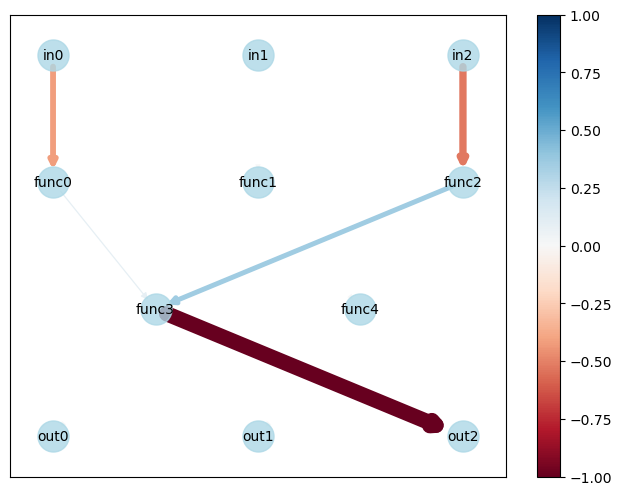

In [138]:
plt.figure(figsize=(8, 6))

# color edges by score 
edge_colors = [G[u][v]['score'] for u,v in G.edges()]
edge_widths = [abs(G[u][v]['score'])*10 for u,v in G.edges()]

norm = plt.Normalize(vmin=-1, vmax=1)
cmap = plt.get_cmap('RdBu')

# draw nodes 
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.8) 
nx.draw_networkx_labels(G, pos, font_size=10)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=1.,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=norm.vmin,
    edge_vmax=norm.vmax
)

# add colorbar 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])              # needed for the colour-bar
plt.colorbar(sm, ax=plt.gca())

plt.show()

In [141]:
y_train[0][2]

tensor(-1.5299, device='cuda:0')

In [129]:
x_train[0]

tensor([-0.8964, -1.9627,  1.5848], device='cuda:0')